In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from importlib import reload
import pandas as pd
import matplotlib
import numpy as np
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from src.constants import PROCESSED_POLCOM_DATA_2022_M_PATH, PROCESSED_POLCOM_DATA_2022_Y_PATH, PROCESSED_AZURE_DATA_PATH

In [3]:
dfs_M = {file.name: pd.read_parquet(file) for file in Path(PROCESSED_POLCOM_DATA_2022_M_PATH).glob("*.parquet")}
dfs_Y = {file.name: pd.read_parquet(file) for file in Path(PROCESSED_POLCOM_DATA_2022_Y_PATH).glob("*.parquet")}

In [4]:
for vm, df in dfs_M.items():
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

In [5]:
def filter_cpu_absolute(cols):
    return [col for col in cols if ("CPU" in col) and "PERCENT" not in col]

# Apply filtering to keep only absolute CPU usage (MHz) metrics
cpu_absolute_only_dfs_M = {file: df[filter_cpu_absolute(df.columns)] for file, df in dfs_M.items()}
cpu_absolute_only_dfs_Y = {file: df[filter_cpu_absolute(df.columns)] for file, df in dfs_Y.items()}

In [6]:
remaining_columns_M = {file: df.columns.tolist() for file, df in cpu_absolute_only_dfs_M.items()}
remaining_columns_Y = {file: df.columns.tolist() for file, df in cpu_absolute_only_dfs_Y.items()}

remaining_columns_M, remaining_columns_Y

({'VM06.parquet': ['CPU_USAGE_MHZ'],
  'VM03.parquet': ['CPU_USAGE_MHZ'],
  'VM07.parquet': ['CPU_USAGE_MHZ'],
  'VM08.parquet': ['CPU_USAGE_MHZ'],
  'VM04.parquet': ['CPU_USAGE_MHZ'],
  'VM01.parquet': ['CPU_USAGE_MHZ'],
  'VM02.parquet': ['CPU_USAGE_MHZ'],
  'VM05.parquet': ['CPU_USAGE_MHZ']},
 {'VM06.parquet': ['CPU_USAGE_MHZ'],
  'VM03.parquet': ['CPU_USAGE_MHZ'],
  'VM07.parquet': ['CPU_USAGE_MHZ'],
  'VM08.parquet': ['CPU_USAGE_MHZ'],
  'VM04.parquet': ['CPU_USAGE_MHZ'],
  'VM01.parquet': ['CPU_USAGE_MHZ'],
  'VM02.parquet': ['CPU_USAGE_MHZ'],
  'VM05.parquet': ['CPU_USAGE_MHZ']})

In [7]:
cpu_absolute_only_dfs_M

{'VM06.parquet':                      CPU_USAGE_MHZ
 DATE                              
 2021-04-14 00:00:00            NaN
 2021-04-15 00:00:00            NaN
 2021-04-16 00:00:00            NaN
 2021-04-17 00:00:00            NaN
 2021-04-18 00:00:00            NaN
 ...                            ...
 2022-04-13 02:00:00        33106.0
 2022-04-13 04:00:00        37600.0
 2022-04-13 06:00:00        59916.0
 2022-04-13 08:00:00            0.0
 2022-04-13 10:00:00            0.0
 
 [695 rows x 1 columns],
 'VM03.parquet':                      CPU_USAGE_MHZ
 DATE                              
 2021-04-13 00:00:00            NaN
 2021-04-14 00:00:00            NaN
 2021-04-15 00:00:00            NaN
 2021-04-16 00:00:00            NaN
 2021-04-17 00:00:00            NaN
 ...                            ...
 2022-04-12 04:00:00       110286.0
 2022-04-12 06:00:00       138615.0
 2022-04-12 08:00:00       139214.0
 2022-04-12 10:00:00            0.0
 2022-04-12 12:00:00            0.0
 
 [6

In [8]:
split_datasets = {}

# Iterate over each VM dataset
for vm, df in cpu_absolute_only_dfs_M.items():
    for col in df.columns:
        # Create a new dataframe for each column and rename the column to a predefined name
        split_df = df[[col]].rename(columns={col: 'METRIC_VALUE'})
        split_datasets[f"{vm}_{col}"] = split_df

In [9]:
cpu_absolute_only_dfs_M = split_datasets

In [10]:
# Updated function to remove both NaNs and leading/trailing zeros while preserving gaps in the middle
def trim_nan_and_zero_edges(df):
    """Removes NaN and zero values only at the beginning and end of a DataFrame while preserving gaps in the middle."""
    first_valid_idx = df[(df.notna()) & (df != 0)].first_valid_index()
    last_valid_idx = df[(df.notna()) & (df != 0)].last_valid_index()
    return df.loc[first_valid_idx:last_valid_idx]

# Apply trimming to each VM dataset
cpu_trimmed_dfs_M = {vm: trim_nan_and_zero_edges(df) for vm, df in cpu_absolute_only_dfs_M.items()}

# Verify results: Check if NaN and zero values at the edges were removed
zero_nan_summary = {vm: (df.isin([0]).sum().sum(), df.isna().sum().sum(), df.index.min(), df.index.max()) for vm, df in cpu_trimmed_dfs_M.items()}
zero_nan_summary


{'VM06.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 12:00:00'),
  Timestamp('2022-04-13 06:00:00')),
 'VM03.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00')),
 'VM07.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 10:00:00'),
  Timestamp('2022-04-13 06:00:00')),
 'VM08.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 10:00:00'),
  Timestamp('2022-04-13 04:00:00')),
 'VM04.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00')),
 'VM01.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 12:00:00'),
  Timestamp('2022-04-13 08:00:00')),
 'VM02.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 14:00:00'),
  Timestamp('2022-04-13 08:00:00')),
 'VM05.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00'))}

In [11]:
len(cpu_trimmed_dfs_M)

8

In [12]:
cpu_trimmed_dfs_M = {vm: df for vm, df in cpu_trimmed_dfs_M.items() if df.isna().sum().sum() == 0}

In [13]:
len(cpu_trimmed_dfs_M)

8

In [14]:
cpu_trimmed_dfs_M

{'VM06.parquet_CPU_USAGE_MHZ':                      METRIC_VALUE
 DATE                             
 2022-03-14 12:00:00       58567.0
 2022-03-14 14:00:00       41881.0
 2022-03-14 16:00:00       31048.0
 2022-03-14 18:00:00       34468.0
 2022-03-14 20:00:00       31933.0
 ...                           ...
 2022-04-12 22:00:00       35485.0
 2022-04-13 00:00:00       40423.0
 2022-04-13 02:00:00       33106.0
 2022-04-13 04:00:00       37600.0
 2022-04-13 06:00:00       59916.0
 
 [358 rows x 1 columns],
 'VM03.parquet_CPU_USAGE_MHZ':                      METRIC_VALUE
 DATE                             
 2022-03-13 14:00:00       60035.0
 2022-03-13 16:00:00       59883.0
 2022-03-13 18:00:00       57655.0
 2022-03-13 20:00:00       50277.0
 2022-03-13 22:00:00       53088.0
 ...                           ...
 2022-04-12 00:00:00       85847.0
 2022-04-12 02:00:00       87466.0
 2022-04-12 04:00:00      110286.0
 2022-04-12 06:00:00      138615.0
 2022-04-12 08:00:00      139214.0
 
 

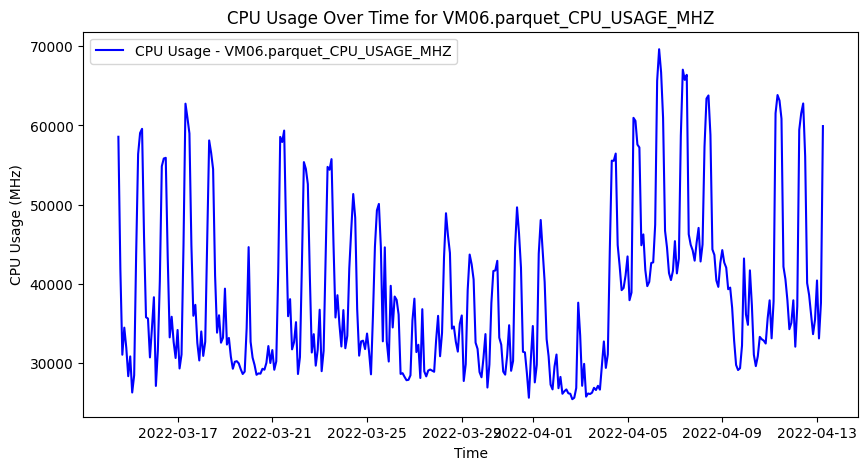

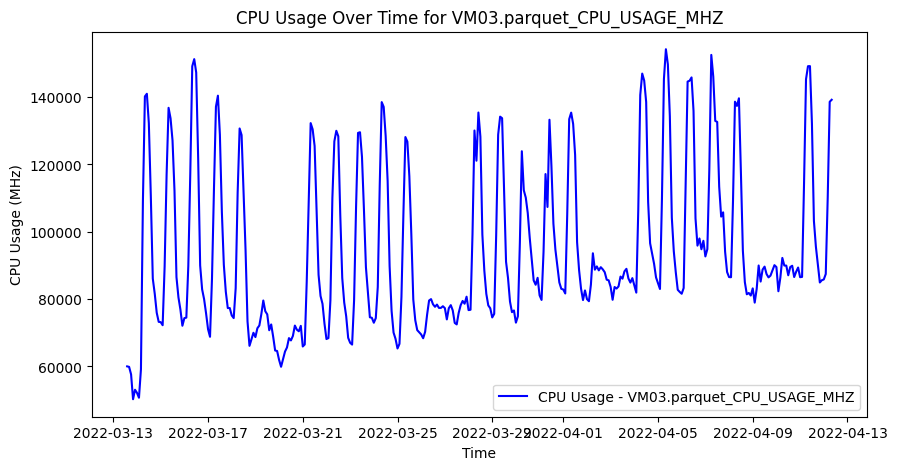

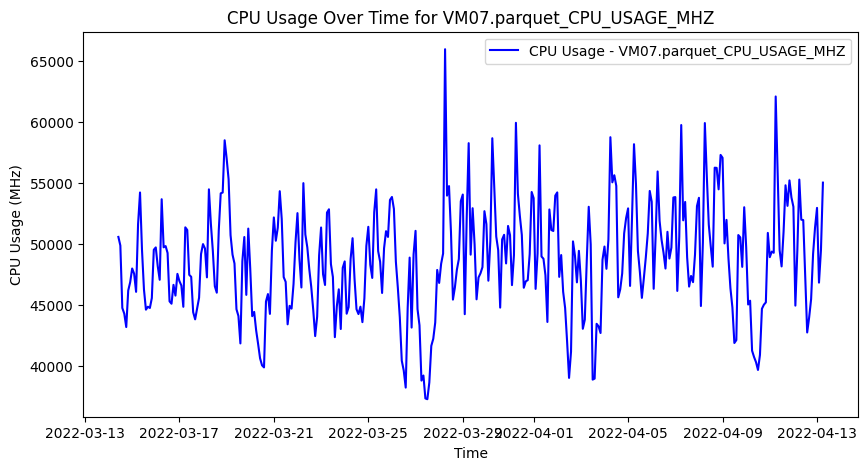

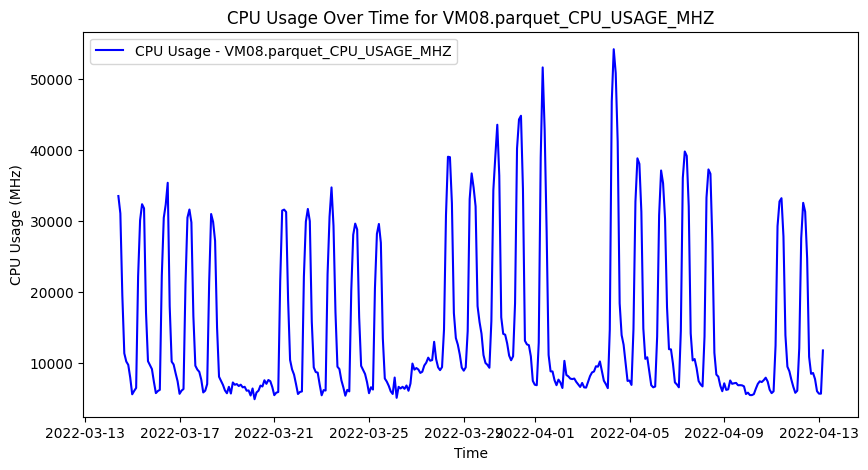

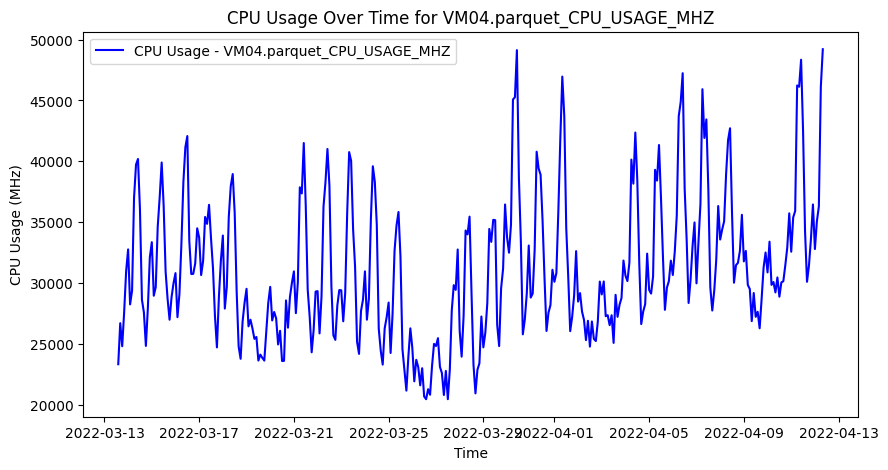

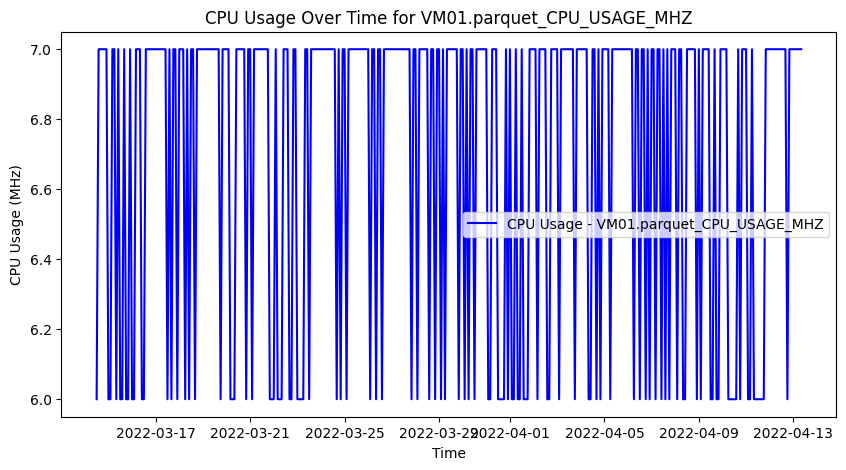

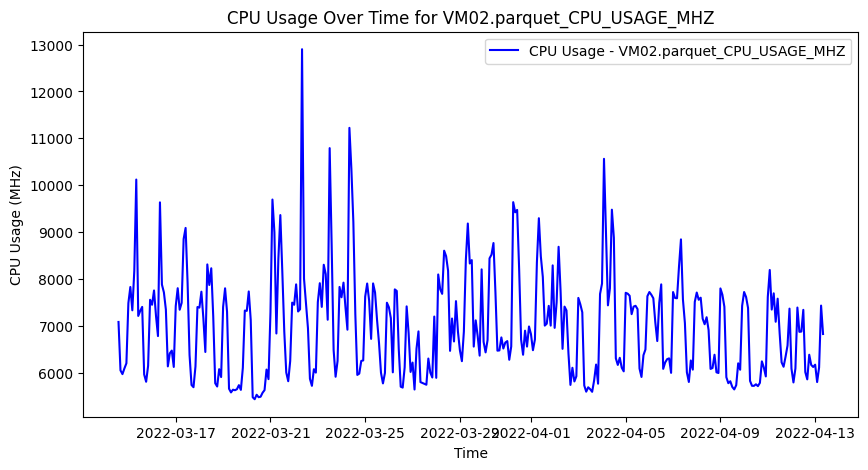

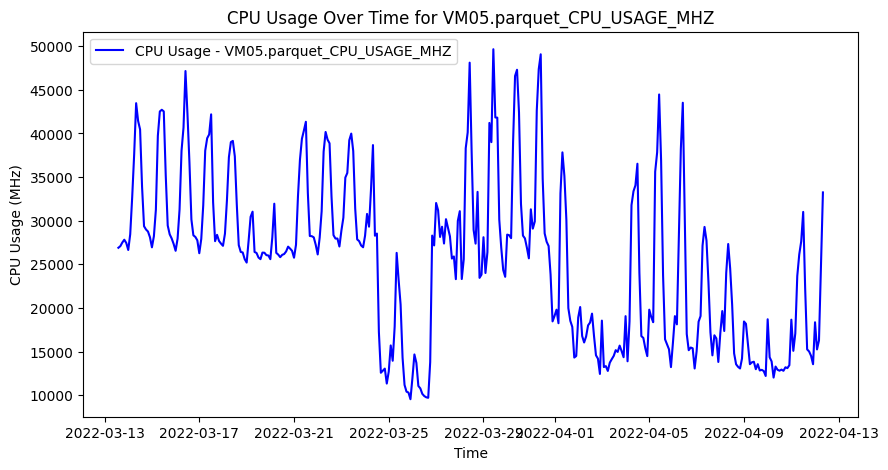

In [15]:
# Plot each VM's CPU usage separately
for vm, df in cpu_trimmed_dfs_M.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df["METRIC_VALUE"], label=f"CPU Usage - {vm}", color="blue")
    plt.xlabel("Time")
    plt.ylabel("CPU Usage (MHz)")
    plt.title(f"CPU Usage Over Time for {vm}")
    plt.legend()
    plt.show()

In [16]:
del cpu_trimmed_dfs_M['VM01.parquet_CPU_USAGE_MHZ']

/tmp/ipykernel_2790/3804601656.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'] = clf.fit_predict(df[[column_name]])  # -1 for anomaly, 1 for normal
/tmp/ipykernel_2790/3804601656.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'] = clf.fit_predict(df[[column_name]])  # -1 for anomaly, 1 for normal
/tmp/ipykernel_2790/3804601656.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

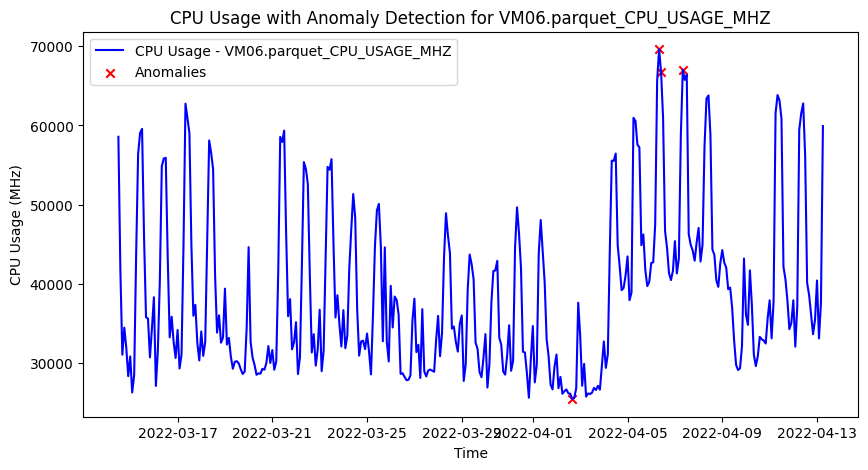

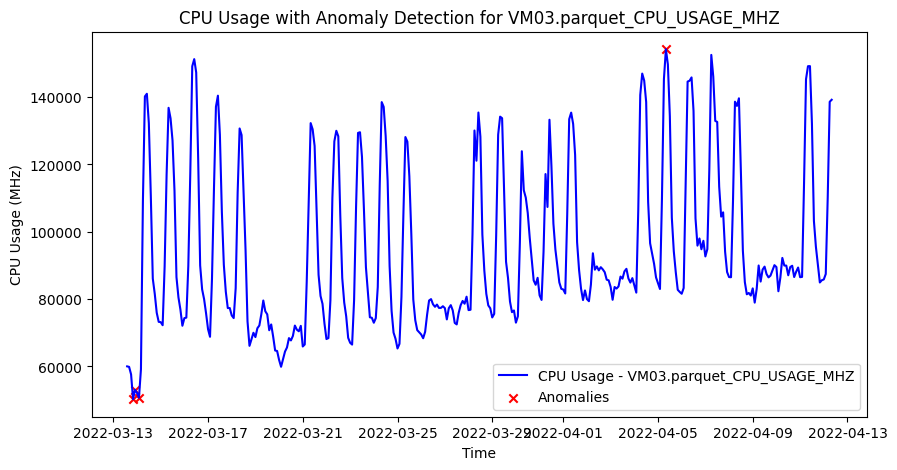

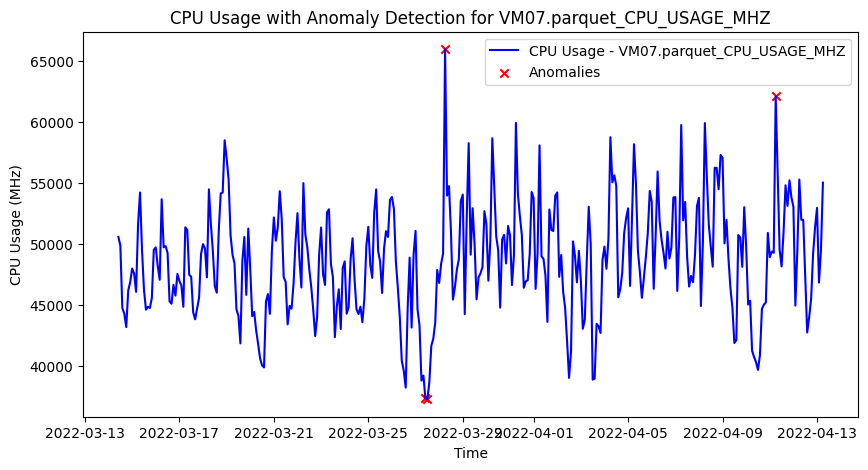

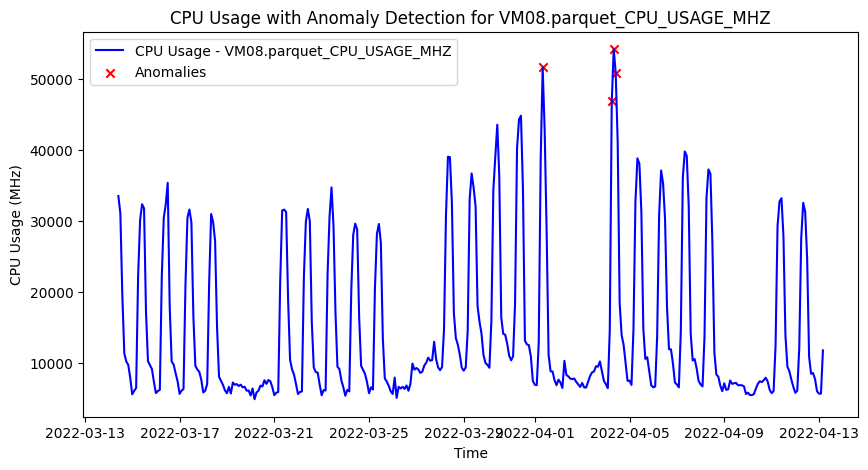

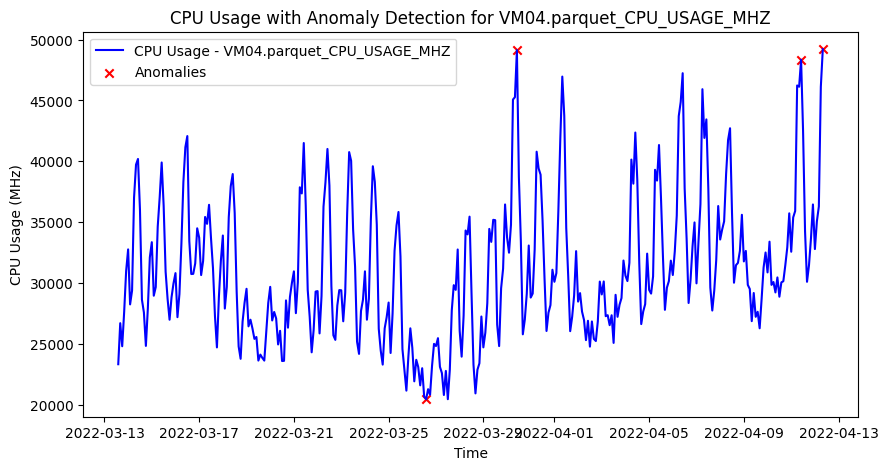

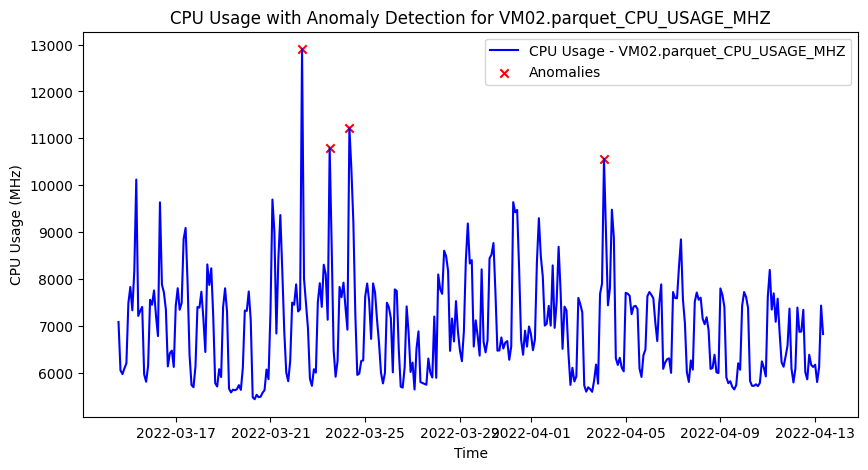

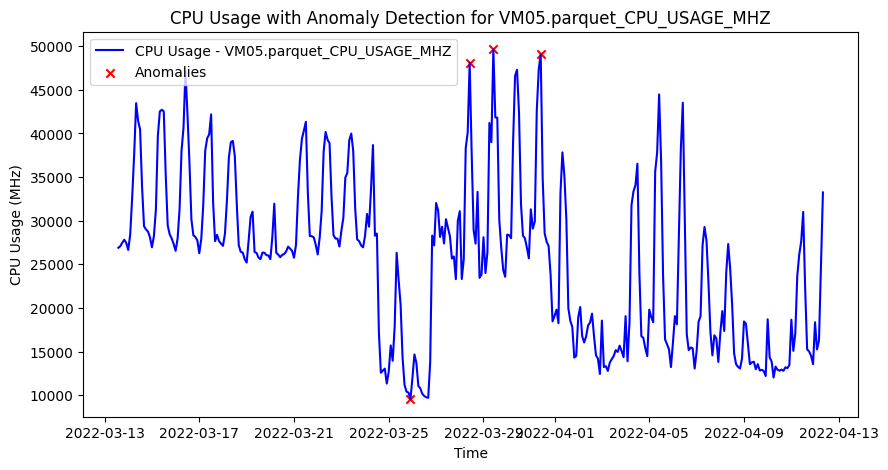

In [17]:
from sklearn.ensemble import IsolationForest

def detect_anomalies(df, column_name, contamination=0.01):
    """Detect anomalies in a time series using Isolation Forest."""
    clf = IsolationForest(contamination=contamination, random_state=42)
    df['anomaly'] = clf.fit_predict(df[[column_name]])  # -1 for anomaly, 1 for normal
    return df

# Apply anomaly detection to each VM dataset
cpu_anomaly_dfs_M = {vm: detect_anomalies(df, column_name="METRIC_VALUE") for vm, df in cpu_trimmed_dfs_M.items()}

# Plot CPU usage with anomalies marked
for vm, df in cpu_anomaly_dfs_M.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df["METRIC_VALUE"], label=f"CPU Usage - {vm}", color="blue")
    
    # Highlight anomalies
    anomalies = df[df['anomaly'] == -1]
    plt.scatter(anomalies.index, anomalies["METRIC_VALUE"], color='red', label='Anomalies', marker='x')
    
    plt.xlabel("Time")
    plt.ylabel("CPU Usage (MHz)")
    plt.title(f"CPU Usage with Anomaly Detection for {vm}")
    plt.legend()
    plt.show()

In [18]:
def create_multi_step_sequences(data, column_name, seq_length=10, forecast_horizon=5):
    """Convert time series into sequences for multi-step forecasting with anomaly flags."""
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        seq_values = data.iloc[i:i+seq_length][[column_name, 'anomaly']].values  # Include anomaly flag
        target_values = data.iloc[i+seq_length:i+seq_length+forecast_horizon][column_name].values
        X.append(seq_values)
        y.append(target_values)
    return np.array(X), np.array(y)

seq_length = 36
forecast_horizon = 36

X_train_list, y_train_list = [], []

for vm, df in cpu_anomaly_dfs_M.items():
    scaler = MinMaxScaler()
    df['METRIC_VALUE'] = scaler.fit_transform(df[['METRIC_VALUE']])

    # Convert anomalies to binary (0 for normal, 1 for anomalies)
    df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

    X, y = create_multi_step_sequences(df, seq_length=seq_length, forecast_horizon=forecast_horizon, column_name="METRIC_VALUE")

    X_train_list.append(X)
    y_train_list.append(y)

# Combine all VM datasets
X_train = np.vstack(X_train_list)
y_train = np.vstack(y_train_list)

print("Final Training Shape:", X_train.shape, y_train.shape)


/tmp/ipykernel_2790/1624497261.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['METRIC_VALUE'] = scaler.fit_transform(df[['METRIC_VALUE']])
/tmp/ipykernel_2790/1624497261.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)
/tmp/ipykernel_2790/1624497261.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Final Training Shape: (2010, 36, 2) (2010, 36)


/tmp/ipykernel_2790/1624497261.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['METRIC_VALUE'] = scaler.fit_transform(df[['METRIC_VALUE']])
/tmp/ipykernel_2790/1624497261.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)


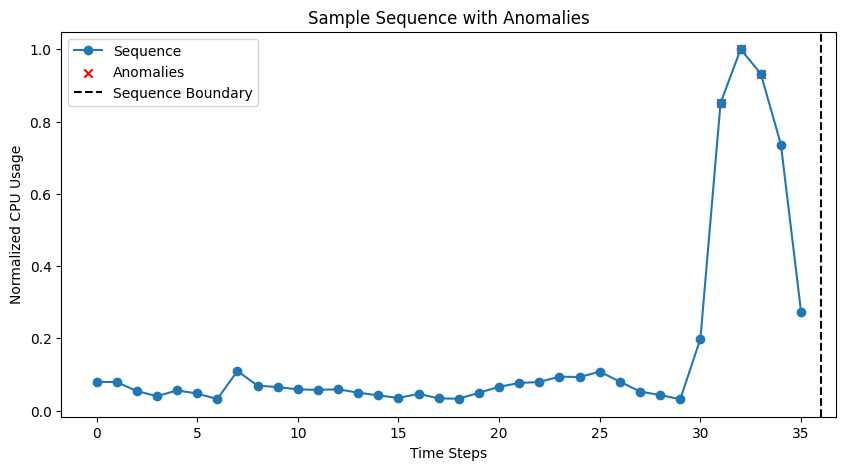

In [36]:
# Plot a sample sequence with anomalies

# Select a random sequence

sample_idx = np.random.randint(0, len(X_train))

# Extract the sequence and target values

sample_seq = X_train[sample_idx]

sample_target = y_train[sample_idx]

# Plot the sequence

plt.figure(figsize=(10, 5))

plt.plot(range(seq_length), sample_seq[:, 0], label="Sequence", marker="o")

# Highlight anomalies

anomaly_indices = np.where(sample_seq[:, 1] == 1)[0]

plt.scatter(anomaly_indices, sample_seq[anomaly_indices, 0], color='red', label='Anomalies', marker='x')

plt.axvline(seq_length, color='black', linestyle='--', label='Sequence Boundary')

plt.xlabel("Time Steps")

plt.ylabel("Normalized CPU Usage")

plt.title("Sample Sequence with Anomalies")

plt.legend()

plt.show()


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Dropout

def build_model(seq_length, forecast_horizon):
    model = Sequential([
        Conv1D(filters=36, kernel_size=3, activation="relu", input_shape=(seq_length, 2)),  # Larger 
        LSTM(32, return_sequences=False),
        Flatten(),
        Dense(32, activation="relu"),  # Intermediate dense layer
        Dropout(0.2),  # Prevent overfitting
        Dense(forecast_horizon)  # Output future values
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Train model
model = build_model(seq_length=seq_length, forecast_horizon=forecast_horizon)
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
63/63 [==============================] - 4s 23ms/step - loss: 0.0997
Epoch 2/10
63/63 [==============================] - 1s 23ms/step - loss: 0.0573
Epoch 3/10
63/63 [==============================] - 1s 21ms/step - loss: 0.0499
Epoch 4/10
63/63 [==============================] - 4s 71ms/step - loss: 0.0458
Epoch 5/10
63/63 [==============================] - 1s 22ms/step - loss: 0.0429
Epoch 6/10
63/63 [==============================] - 1s 23ms/step - loss: 0.0395
Epoch 7/10
63/63 [==============================] - 1s 23ms/step - loss: 0.0363
Epoch 8/10
63/63 [==============================] - 2s 26ms/step - loss: 0.0352
Epoch 9/10
63/63 [==============================] - 1s 23ms/step - loss: 0.0348
Epoch 10/10
63/63 [==============================] - 2s 24ms/step - loss: 0.0342


In [41]:
# save model
model.save("../models/cpu_usage_model")

INFO:tensorflow:Assets written to: models/cpu_usage_model/assets


INFO:tensorflow:Assets written to: models/cpu_usage_model/assets


In [ ]:
# Load model

from tensorflow.keras.models import load_model

model = load_model("../models/cpu_usage_model")

In [38]:
# Read the CSV file with timestamp parsing.
df = pd.read_csv(f'{PROCESSED_AZURE_DATA_PATH}azure.csv', parse_dates=['timestamp'])

# Clean column names: e.g., "avg cpu" becomes "avg_cpu"
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Set the timestamp as the index.
df.set_index('timestamp', inplace=True)

# Resample the data to 2-hour intervals (using mean aggregation) to match your training data.
df_resampled = df.resample('2H').mean().dropna()

# Detect anomalies in the resampled data
df_resampled = detect_anomalies(df_resampled, column_name="avg_cpu")

# Use only the avg_cpu column and anomaly column.
data = df_resampled[['avg_cpu', 'anomaly']].values  # shape: (num_timesteps, 2)

# Scale data
scaler = MinMaxScaler()
azure_scaled = scaler.fit_transform(data)

azure_scaled_df = pd.DataFrame(azure_scaled, index=df_resampled.index, columns=["avg_cpu", "anomaly"])

# Create sequences including anomaly information
X_test, _ = create_multi_step_sequences(azure_scaled_df, column_name="avg_cpu", seq_length=seq_length, forecast_horizon=forecast_horizon)

print("Azure Test Data Shape:", X_test.shape)

Azure Test Data Shape: (289, 36, 2)


In [39]:
y_pred = model.predict(X_test)

print(f"Predicted CPU usage (normalized) for next {forecast_horizon} steps:", y_pred)

10/10 [==============================] - 0s 7ms/step
Predicted CPU usage (normalized) for next 36 steps: [[0.2884101  0.26738727 0.22471863 ... 0.6728058  0.6774585  0.6263403 ]
 [0.2579485  0.25497538 0.21026948 ... 0.65278053 0.64927053 0.6052648 ]
 [0.23787463 0.24850449 0.20631838 ... 0.6422155  0.6359354  0.59860635]
 ...
 [0.35063288 0.29517323 0.27827984 ... 0.61892307 0.58760107 0.5556665 ]
 [0.34286025 0.27806646 0.26078582 ... 0.6275622  0.5761812  0.53949034]
 [0.29233587 0.24843526 0.2244293  ... 0.6097417  0.53324103 0.501359  ]]


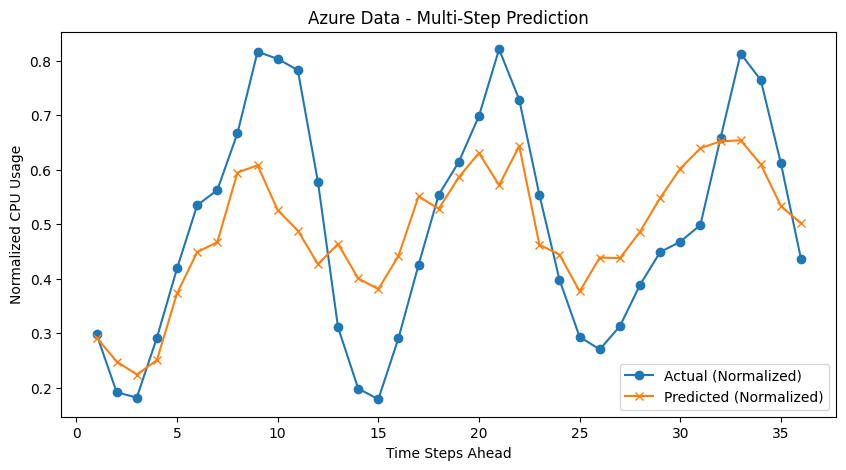

In [40]:
# Select the last sequence's prediction
y_pred_last = y_pred[-1]  # Take the last predicted sequence (shape: forecast_horizon,)

# Select the corresponding last actual values
y_actual_last = azure_scaled_df["avg_cpu"].iloc[-forecast_horizon:].values  # Match forecast_horizon

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(range(1, forecast_horizon + 1), y_actual_last, label="Actual (Normalized)", marker="o")
plt.plot(range(1, forecast_horizon + 1), y_pred_last, label="Predicted (Normalized)", marker="x")
plt.xlabel("Time Steps Ahead")
plt.ylabel("Normalized CPU Usage")
plt.title("Azure Data - Multi-Step Prediction")
plt.legend()
plt.show()